## We are here to explore the most recent trends for Airbnb accommodation in different cities. Ready, let's go!
Thanks to Airbnb Open data source: http://insideairbnb.com/get-the-data.html

[Data exploratory Questions]
1.	How does the average availability of Airbnb homes vary over time in each city? Is there a clear seasonal pattern for the average nightly rate on Airbnb in the chosen city? Is there a clear weekly pattern?
2.	Which neighborhood is the most expensive? Which property type is most common? 
3.	How does the trends compare between cities? Seattle, Boston and Beijing?

[Model prediction] 
4.	Can we predict the listing price? We know that price quite depends on the location, but many other factors may help predict the listing price such as room type, property type, size, #beds, any correlation between # of comments and price? E.g. Multiple regression analysis can be done in Python to put these variables together to predict the listing price of a property？

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
#import sys

# Import plotting modules
import matplotlib.pyplot as plt
import matplotlib.dates as plotdates
import matplotlib.ticker as ticker
import seaborn as sns

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# import libraries for price prediction
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
#from lightgbm import LGBMRegressor

# import libraries for NLP processing - optional
#from sklearn.feature_extraction import text 
#import nltk
#from nltk.tokenize import word_tokenize 
#from nltk import pos_tag, bigrams, FreqDist, ne_chunk
#import detectEnglish

In [3]:
# define city and read in dataset
city = 'beijing'
calendar = pd.read_csv( city + '/calendar.csv.gz')
listing = pd.read_csv(city + '/listings.csv.gz')
review =pd.read_csv(city + '/reviews.csv.gz')

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the ' + city+ ' calendar data.')
print('We have', listing.id.nunique(), 'listings in the ' + city+ '  listing data.')
print('We have', review.shape[0], 'reviews for', review.listing_id.nunique(),'listings in the ' + city+ ' review data')

We have 366 days and 34384 unique listings in the beijing calendar data.
We have 34384 listings in the beijing  listing data.
We have 240959 reviews for 20625 listings in the beijing review data


In [5]:
#listing.head()
#review.head()
#calendar.head()
#listings_seattle.iloc[1000:1200,]
#calendar.info()
#calendar.dtypes

In [6]:
print("Listing dataset has %2d records and %2d columns" %(listing.shape[0],listing.shape[1]))
print("Calendar dataset has %2d records and %2d columns" %(calendar.shape[0],calendar.shape[1]))
print("Review dataset has %2d records and %2d columns" %(review.shape[0],review.shape[1]))

Listing dataset has 34384 records and 106 columns
Calendar dataset has 12550393 records and  7 columns
Review dataset has 240959 records and  6 columns


### Prepare Calendar Data Set to Answer Question 1

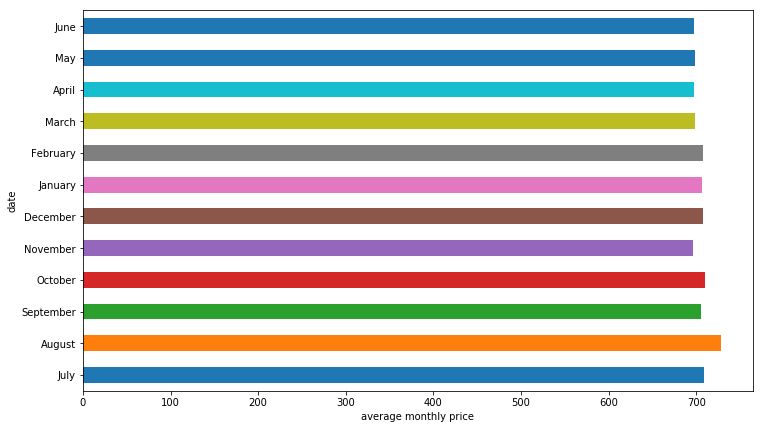

In [7]:
#changing data type for price and date
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)

calendar['date'] = pd.to_datetime(calendar['date'])
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=False)['price'].mean()
mean_of_month.plot(kind = 'barh' , figsize = (12,7))
plt.xlabel('average monthly price');

#### Q: Is there a clear seasonal pattern for the average nightly rate on Airbnb in the chosen city? Is there a clear weekly pattern?
A: In Beijing, surprisingly there is no clear price difference between the month. 

In [8]:
# calendar.isnull().sum()
# calendar.info()

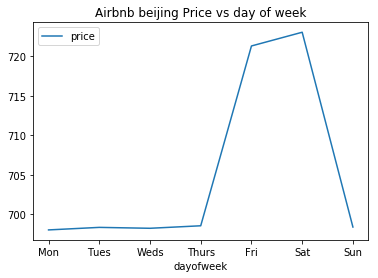

In [9]:
calendar['dayofweek'] = calendar.date.dt.weekday_name
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek','price']]
price_week = price_week.groupby(['dayofweek']).mean().reindex(cats)
#price_week.drop(['listing_id', 'minimum_nights','maximum_nights'] ,axis=1, inplace=True)
price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.title('Airbnb '+ city + ' Price vs day of week')
plt.xticks(ticks, labels);

In [10]:
print(price_week.iloc[0:10,].round(2))
# price_week.groupby(['dayofweek'])['price'].describe()

            price
dayofweek        
Monday     698.03
Tuesday    698.35
Wednesday  698.24
Thursday   698.56
Friday     721.33
Saturday   723.07
Sunday     698.40


#### Q: Is there a clear weekly pattern on the price?
A：Yes, but the difference is not that big. Weekend Rate is generally 3.5% higher than that in the weekdays. 

#### Q: How does the average availability of Airbnb homes vary over time in each city?
Find out daily average availability for the time period. Convert available column to 0 if available and 1 if not.

In [11]:
calendar.available.value_counts()
#f (false) means not available, t(true) means available.

t    7590896
f    4959497
Name: available, dtype: int64

In [12]:
# calendar['maximum_nights'].value_counts()

In [13]:
calendar.date.min(), calendar.date.max()

(Timestamp('2019-07-15 00:00:00'), Timestamp('2020-07-14 00:00:00'))

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


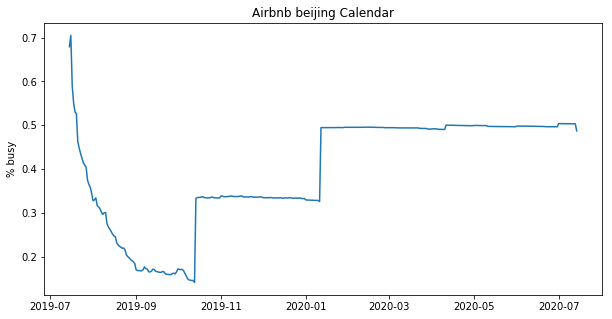

In [14]:
# Find out daily average availability for the time period. Convert available column to 0 if available and 1 if not.
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date'] = pd.to_datetime(calendar_new['date'])
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb '+ city + ' Calendar')
plt.ylabel('% busy')
plt.show();

#### Q: How does the average availability of Airbnb homes vary over time in each city?
Beijing has the highest occupancy rate in July, sensible result but that's actually one of the hottest month in the year. 

In [15]:
#calendar.drop_duplicates()
#calendar.drop_duplicates(keep='first', inplace=True)
#calendar.info()

### Prepare Listing Data Set to Answer Question 2

In [16]:
#checking for missing values in the listing data frame
def identify_null_col(dataframe):
    """Identify columns that have missing data in the dataframe
    Args:
        dataframe: input dataframe to identify missing data
    Returns:
        dataframe: dataframe of column names as index, # missing records, % missing records
    """
    null_col = dataframe.columns[dataframe.isna().sum()>0]
    col_null_val = dataframe[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (dataframe[null_col].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    nulls_df = pd.DataFrame(col_null_val,columns=['#Nulls'])
    nulls_df['%Nulls']=per_null_val
    print('Number of columns with missing data:',nulls_df.shape[0])
    return nulls_df
identify_null_col(listing)

Number of columns with missing data: 55


,#Nulls,%Nulls
host_acceptance_rate,34384,100.000000
xl_picture_url,34384,100.000000
thumbnail_url,34384,100.000000
neighbourhood_group_cleansed,34384,100.000000
medium_url,34384,100.000000
license,34382,99.994183
jurisdiction_names,34381,99.991275
square_feet,34365,99.944742
weekly_price,34032,98.976268
monthly_price,34026,98.958818


In [17]:
#listing.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

In [18]:
listing.review_scores_rating.describe()

count    20199.000000
mean        94.979900
std         10.299159
min         20.000000
25%         94.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


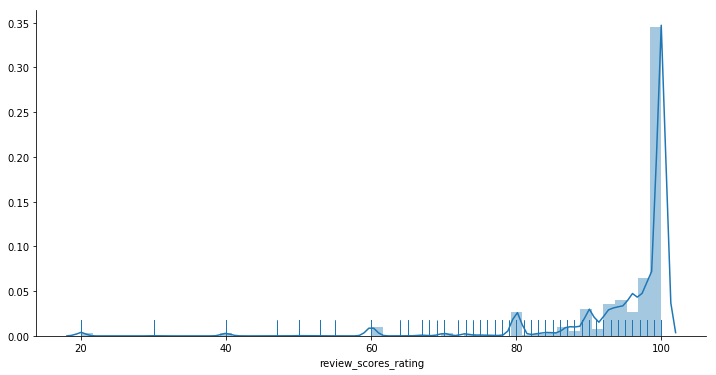

In [19]:
#understand distribution of review rating
plt.figure(figsize=(12,6))
sns.distplot(listing.review_scores_rating.dropna(), rug=True)
sns.despine()
plt.show();

In [20]:
#convert price info to float type
listing['price'] = listing['price'].str.replace(',', '')
listing['price'] = listing['price'].str.replace('$', '')
listing['price'] = listing['price'].astype(float)
listing['price'].describe()

count    34384.000000
mean       656.389367
std       1694.046124
min          0.000000
25%        255.000000
50%        399.000000
75%        599.000000
max      68980.000000
Name: price, dtype: float64

In [37]:
listing.iloc[np.argmax(listing['price'])]

id                                                                                       28134193
listing_url                                                 https://www.airbnb.com/rooms/28134193
scrape_id                                                                          20190715155043
last_scraped                                                                           2019-07-16
name                                                                                  此房不能租,不要询问了
summary                                                                                       NaN
space                                                                                         NaN
description                                                                                   NaN
experiences_offered                                                                          none
neighborhood_overview                                                                         NaN
notes               

In [38]:
listing.iloc[np.argmax(listing['price'])]['neighbourhood_cleansed']

'海淀区'

cutoff is 5738.53


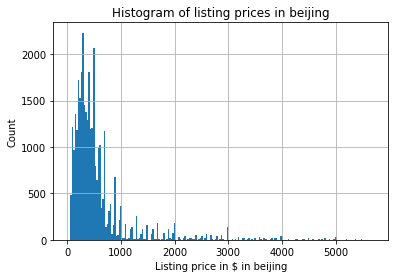

In [39]:
outlier = listing.price.mean()+ 3*listing.price.std()
print ('cutoff is {:.2f}'.format(outlier))
#print ('cutoff is %.2f %.4f' % (outlier, outlier))

listing.loc[(listing.price <= outlier)  & (listing.price > 0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $ in ' + city)
plt.title('Histogram of listing prices in ' + city);

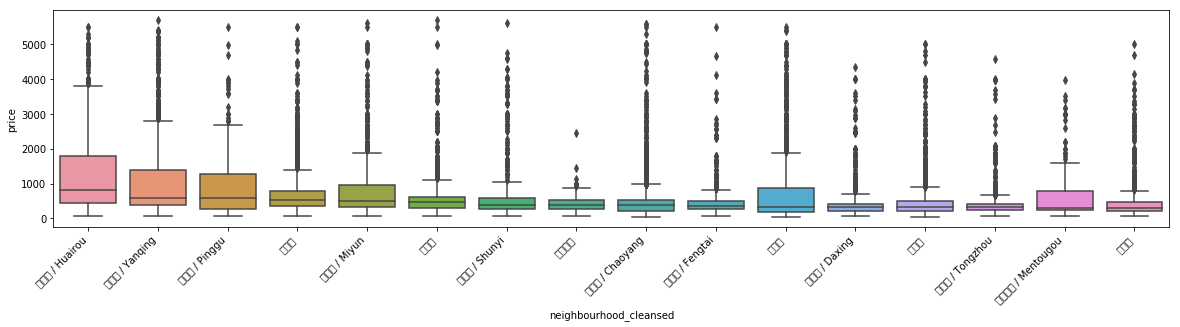

In [40]:
sort_price = listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('neighbourhood_cleansed')['price'].median()\
            .sort_values(ascending=False).index
plt.figure(figsize = (20,4))
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [41]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('neighbourhood_cleansed')['price']\
        .describe().sort_values('count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
朝阳区 / Chaoyang,11855.0,434.362716,377.979822,34.0,220.0,372.0,530.00,5580.0
东城区,3761.0,665.828237,551.171090,69.0,358.0,516.0,791.00,5498.0
海淀区,3590.0,419.261838,416.475797,28.0,220.0,323.0,495.00,5002.0
丰台区 / Fengtai,2065.0,420.943826,330.121947,69.0,268.0,371.0,495.00,5488.0
西城区,1975.0,579.224810,544.947344,62.0,296.0,468.0,626.00,5697.0
延庆县 / Yanqing,1901.0,1068.525513,1078.818285,69.0,378.0,599.0,1376.00,5680.0
密云县 / Miyun,1475.0,801.816271,803.628313,83.0,330.0,502.0,966.50,5598.0
通州区 / Tongzhou,1433.0,395.367760,402.236240,62.0,255.0,317.0,420.00,4583.0
顺义区 / Shunyi,1264.0,543.098892,628.238870,62.0,268.0,378.0,578.00,5598.0


### Q: Which neighborhood is the most expensive and which neighbourhood has most units? 
A: Huairou District actually has the highest median price. It's one of the suburb area, so the unit must be big ones. Chaoyang District, being the central district, has a lot more listing rooms. 

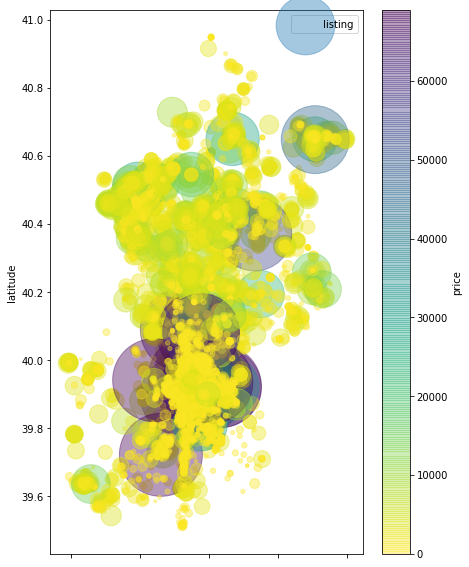

In [42]:
# Price based on geographical data
listing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4
             ,s=listing['price']/10
             , label = 'listing'
            , c = 'price', figsize =(7,10)
            , cmap = plt.get_cmap("viridis_r")
            , colorbar=True);

plt.legend();

In [43]:
#inspect and understand more of listing data
unique_host = listing['host_id'].unique()
'Number of unique hosts in listing dataset:', len(unique_host)
# %Superhosts in the dataset
listing['host_is_superhost'].value_counts()/listing.shape[0]*100

f    69.890065
t    30.051768
Name: host_is_superhost, dtype: float64

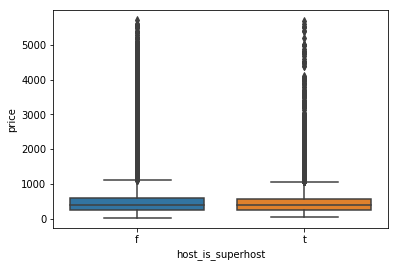

In [44]:
sns.boxplot(y='price', x='host_is_superhost', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)])
plt.show();

In [45]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('host_is_superhost')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,,,,,,,,
f,23823.0,587.529740,675.610416,28.0,254.0,399.0,599.0,5697.0
t,10294.0,523.431125,529.301507,62.0,261.0,399.0,585.0,5680.0


##### for Beijing, being a superhost does not seem to grant a better price for the house.. a little bit counter-intuititve... 

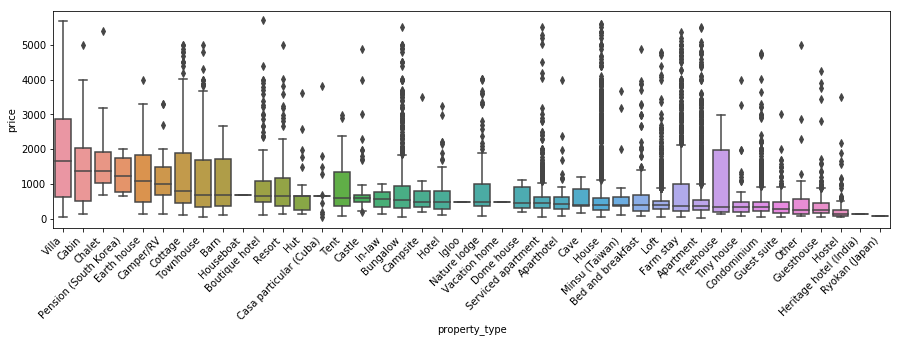

In [46]:
plt.figure(figsize = (15,4))
sort_price = listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('property_type')['price'].median()\
                    .sort_values(ascending=False).index
sns.boxplot(y='price', x='property_type', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [47]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].property_type.value_counts().sort_values(ascending = False)

listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('property_type')['price'].describe().sort_values('count',ascending = False)
#listing.loc[(listing.price <= outlier) & (listing.price > 0)]['price'].median()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,12229.0,453.294709,383.407612,28.0,248.00,385.0,550.00,5498.0
Condominium,5871.0,404.916028,307.026192,62.0,220.00,337.0,502.00,4755.0
House,5590.0,599.047406,679.686052,48.0,248.00,399.0,599.00,5598.0
Loft,2466.0,480.456204,403.776603,69.0,296.00,392.0,530.00,4800.0
Serviced apartment,1780.0,541.893258,420.728029,69.0,330.00,447.0,626.00,5498.0
Farm stay,1101.0,874.996367,1044.903246,69.0,241.00,385.0,997.00,5350.0
Bungalow,1028.0,831.611868,843.626632,62.0,330.00,553.5,936.00,5501.0
Villa,839.0,1878.355185,1411.307350,69.0,619.00,1678.0,2883.00,5680.0
Townhouse,453.0,1125.534216,1036.291071,69.0,337.00,702.0,1686.00,4979.0


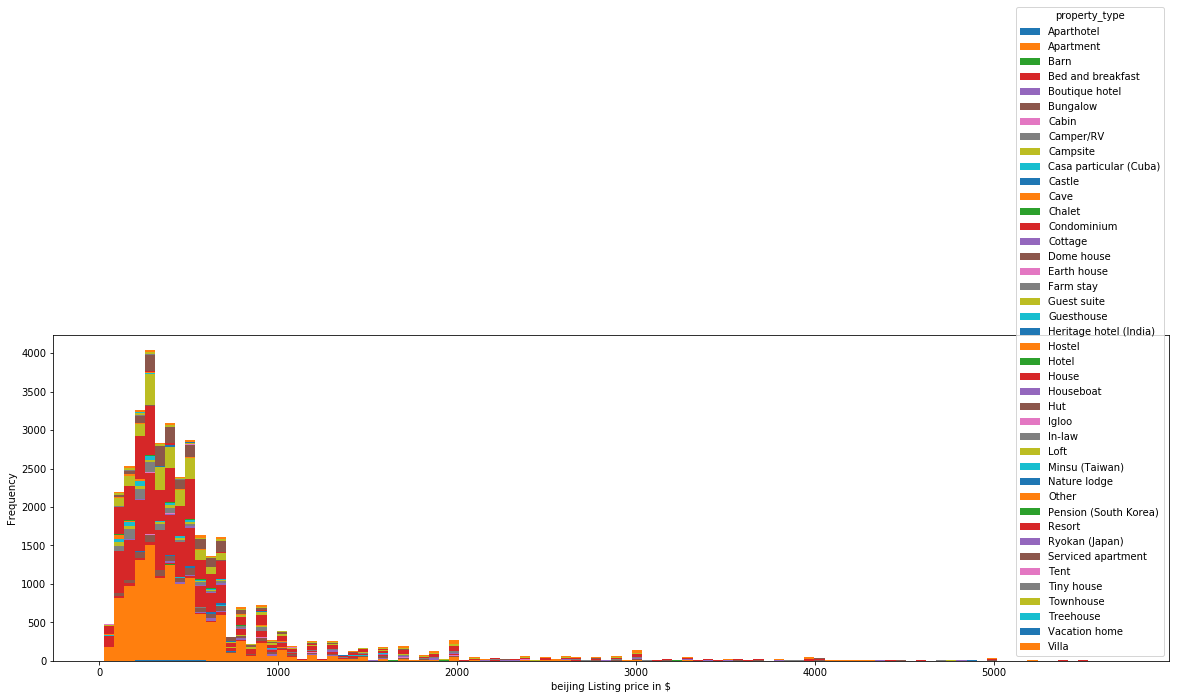

In [48]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].pivot(columns = 'property_type', values = 'price')\
        .plot.hist(stacked = True, bins=100, figsize = (20,6))

plt.xlabel(city + ' Listing price in $'); 

#### Q: Which property type is most common? 
A: In Beijing, close to half of the lsitings are apartment type, given it's a city with higher population. So apartment is a practical type of property for renting.  

#### Other Data Exploration for Listing

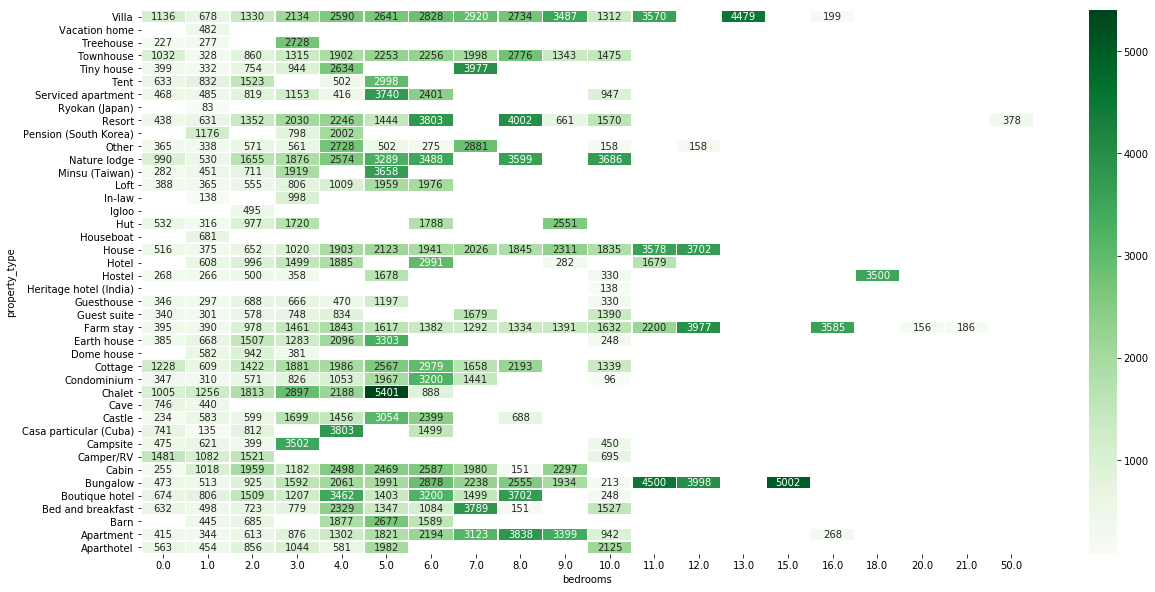

In [51]:
plt.figure(figsize = (20,10))
sns.heatmap(listing.loc[(listing.price <= outlier) & (listing.price > 0)]\
                .groupby(['property_type', 'bedrooms'])\
                .mean()['price']\
                .reset_index()\
                .pivot('property_type', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)
plt.show();

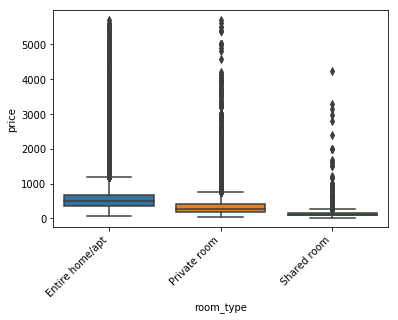

In [52]:
sort_price = listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('room_type')['price'].median()\
                    .sort_values(ascending=False).index
sns.boxplot(y='price', x='room_type', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show(); 

### Modelling Listing Price 
#### Data preprocessing and feature engineering

#### Handle categorical and missing data for Listing.csv

In [53]:
'''listing.amenities = listing.amenities.str.replace("[{}]", "").str.replace('"', "")
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listing['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)'''

'listing.amenities = listing.amenities.str.replace("[{}]", "").str.replace(\'"\', "")\nfrom sklearn.feature_extraction.text import CountVectorizer\ncount_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(\',\'))\namenities = count_vectorizer.fit_transform(listing[\'amenities\'])\ndf_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())\ndf_amenities = df_amenities.drop(\'\',1)'

In [54]:
# convert binary column into interger format
columns =  ['host_is_superhost',  'instant_bookable']

for c in columns:
    listing[c] = listing[c].replace('f',0,regex=True)
    listing[c] = listing[c].replace('t',1,regex=True)

In [55]:
# fill NA
listing['security_deposit'] = listing['security_deposit'].fillna(value=0)
listing['security_deposit'] = listing['security_deposit'].replace( '[\$,)]','', regex=True ).astype(float)
listing['cleaning_fee'] = listing['cleaning_fee'].fillna(value=0)
listing['cleaning_fee'] = listing['cleaning_fee'].replace( '[\$,)]','', regex=True ).astype(float)


In [56]:
#listing['zipcode'] = listing['zipcode'].str.replace('98104-4417','98104').astype(float)

In [73]:
listing_new = listing[['host_is_superhost', 'host_total_listings_count', 'bedrooms', 'number_of_reviews','review_scores_rating',
                       'neighbourhood_cleansed','room_type','property_type','accommodates', 'square_feet','price']]

In [74]:
sorted(listing.columns.tolist())
sorted(listing_new.columns.tolist())
#listing_new.info()

['accommodates',
 'bedrooms',
 'host_is_superhost',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'price',
 'property_type',
 'review_scores_rating',
 'room_type',
 'square_feet']

In [75]:
corr = listing_new.loc[(listing_new.price <= outlier) & (listing_new.price > 0)].dropna().corr()

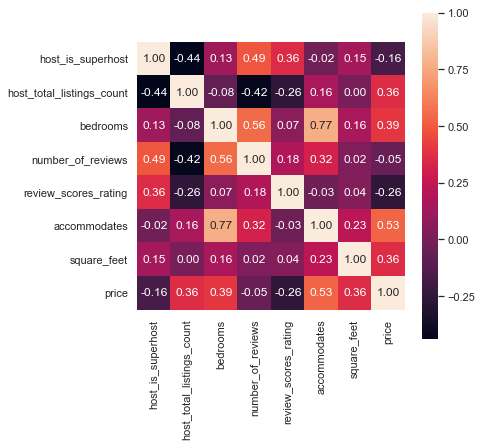

In [62]:
plt.figure(figsize = (6,6))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f')
plt.show();

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


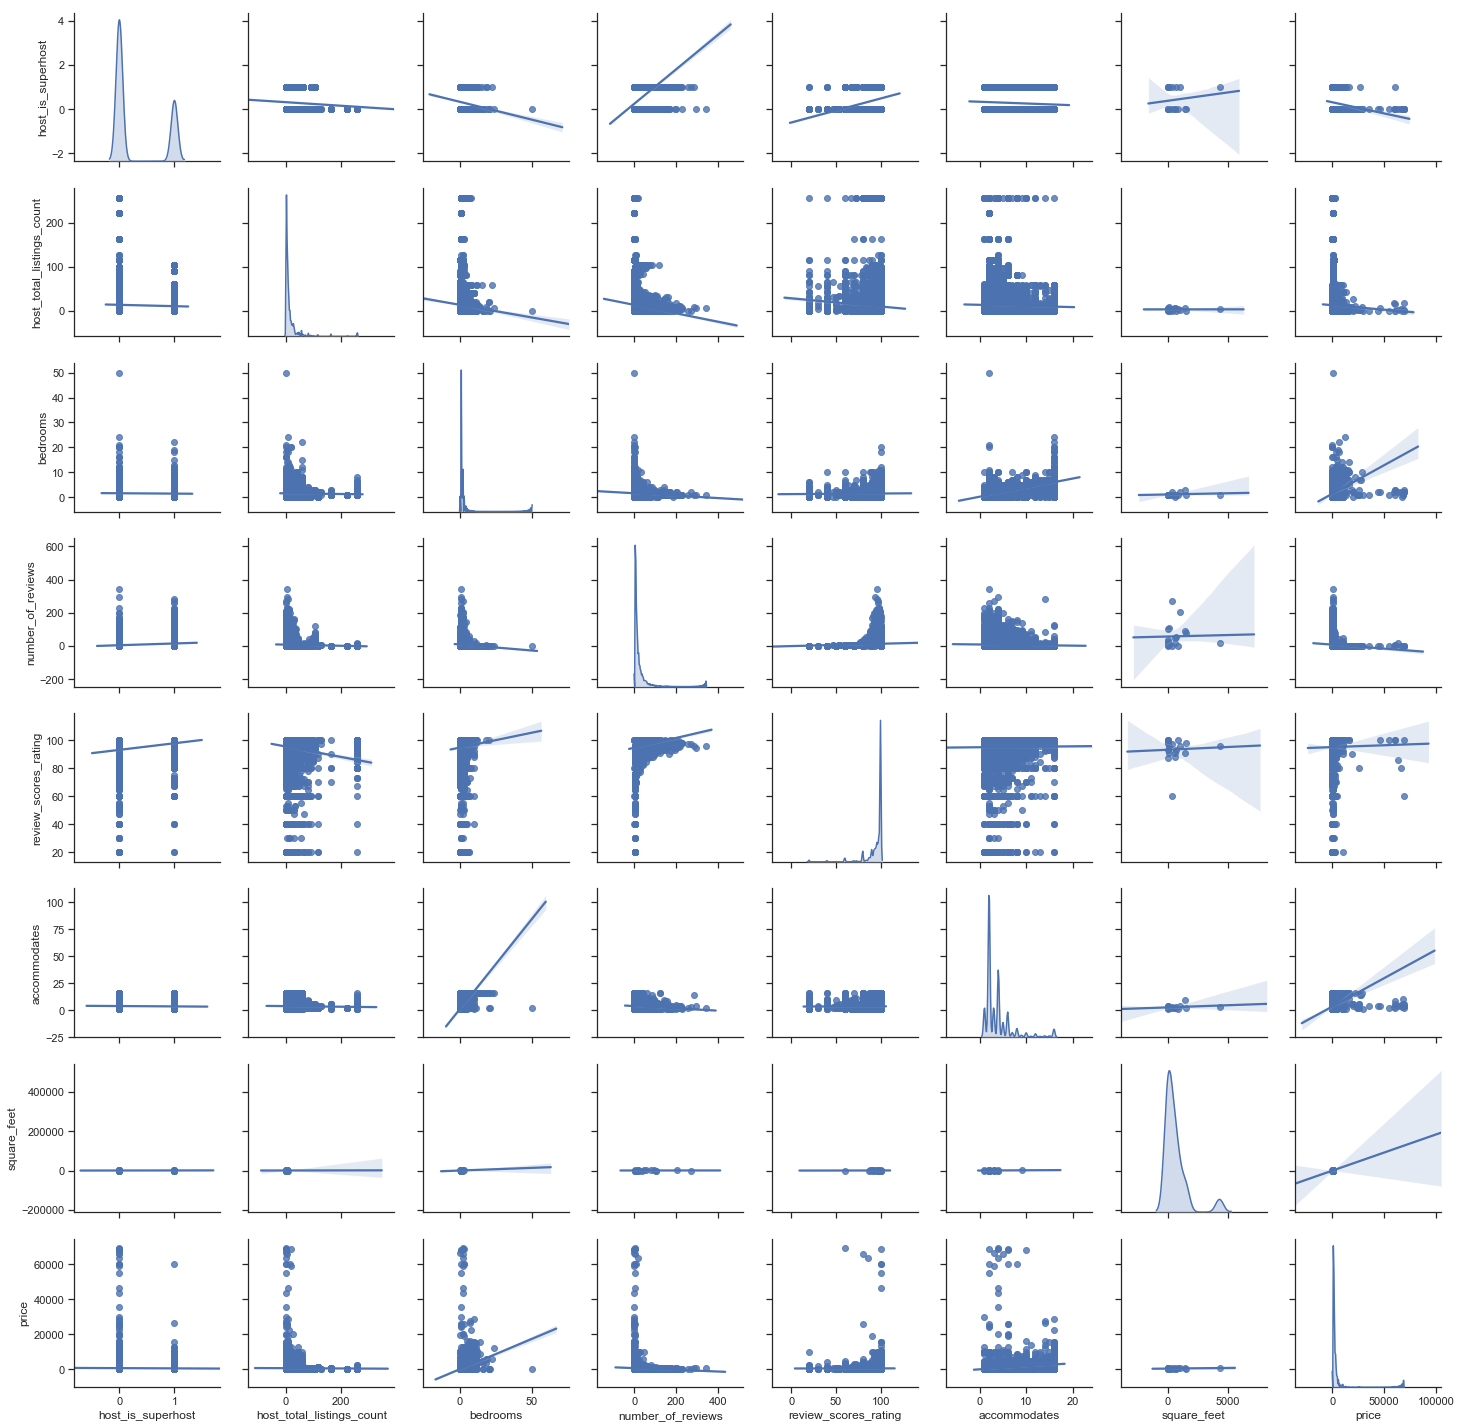

In [63]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(listing_new,diag_kind='kde',palette="husl", kind='reg')

In [76]:
for col in listing_new.columns[listing_new.isnull().any()]:
    print('Filling NA for column {}'.format(col))
    listing_new[col] = listing_new[col].fillna(listing_new[col].median())

Filling NA for column host_is_superhost
Filling NA for column host_total_listings_count
Filling NA for column bedrooms

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



Filling NA for column review_scores_rating
Filling NA for column square_feet


In [77]:
#one hot encoding
listing_new = pd.get_dummies(listing_new, columns = ['property_type', 'room_type','neighbourhood_cleansed'], drop_first=True)

In [78]:
#listing_new = pd.concat([listing_new, df_amenities], axis=1, join='inner')

In [79]:
sorted(listing_new.columns.tolist())

['accommodates',
 'bedrooms',
 'host_is_superhost',
 'host_total_listings_count',
 'neighbourhood_cleansed_丰台区 / Fengtai',
 'neighbourhood_cleansed_大兴区 / Daxing',
 'neighbourhood_cleansed_密云县 / Miyun',
 'neighbourhood_cleansed_平谷区 / Pinggu',
 'neighbourhood_cleansed_延庆县 / Yanqing',
 'neighbourhood_cleansed_怀柔区 / Huairou',
 'neighbourhood_cleansed_房山区',
 'neighbourhood_cleansed_昌平区',
 'neighbourhood_cleansed_朝阳区 / Chaoyang',
 'neighbourhood_cleansed_海淀区',
 'neighbourhood_cleansed_石景山区',
 'neighbourhood_cleansed_西城区',
 'neighbourhood_cleansed_通州区 / Tongzhou',
 'neighbourhood_cleansed_门头沟区 / Mentougou',
 'neighbourhood_cleansed_顺义区 / Shunyi',
 'number_of_reviews',
 'price',
 'property_type_Apartment',
 'property_type_Barn',
 'property_type_Bed and breakfast',
 'property_type_Boutique hotel',
 'property_type_Bungalow',
 'property_type_Cabin',
 'property_type_Camper/RV',
 'property_type_Campsite',
 'property_type_Casa particular (Cuba)',
 'property_type_Castle',
 'property_type_Cave',
 'pro

In [81]:
listing_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34384 entries, 0 to 34383
Data columns (total 66 columns):
host_is_superhost                          34384 non-null float64
host_total_listings_count                  34384 non-null float64
bedrooms                                   34384 non-null float64
number_of_reviews                          34384 non-null int64
review_scores_rating                       34384 non-null float64
accommodates                               34384 non-null int64
square_feet                                34384 non-null float64
price                                      34384 non-null float64
property_type_Apartment                    34384 non-null uint8
property_type_Barn                         34384 non-null uint8
property_type_Bed and breakfast            34384 non-null uint8
property_type_Boutique hotel               34384 non-null uint8
property_type_Bungalow                     34384 non-null uint8
property_type_Cabin                        3438

In [82]:
listing_new.head()

,host_is_superhost,host_total_listings_count,bedrooms,number_of_reviews,review_scores_rating,accommodates,square_feet,price,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Heritage hotel (India),property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Igloo,property_type_In-law,property_type_Loft,property_type_Minsu (Taiwan),property_type_Nature lodge,property_type_Other,property_type_Pension (South Korea),property_type_Resort,property_type_Ryokan (Japan),property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,room_type_Private room,room_type_Shared room,neighbourhood_cleansed_丰台区 / Fengtai,neighbourhood_cleansed_大兴区 / Daxing,neighbourhood_cleansed_密云县 / Miyun,neighbourhood_cleansed_平谷区 / Pinggu,neighbourhood_cleansed_延庆县 / Yanqing,neighbourhood_cleansed_怀柔区 / Huairou,neighbourhood_cleansed_房山区,neighbourhood_cleansed_昌平区,neighbourhood_cleansed_朝阳区 / Chaoyang,neighbourhood_cleansed_海淀区,neighbourhood_cleansed_石景山区,neighbourhood_cleansed_西城区,neighbourhood_cleansed_通州区 / Tongzhou,neighbourhood_cleansed_门头沟区 / Mentougou,neighbourhood_cleansed_顺义区 / Shunyi
0,0.0,6.0,3.0,92,91.0,9,1464.0,812.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.0,4.0,1.0,2,100.0,2,323.0,1197.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,4.0,1.0,60,93.0,2,323.0,667.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.0,4.0,1.0,9,98.0,2,323.0,619.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.0,4.0,1.0,2,100.0,1,818.0,619.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [83]:
'''for cat_feature in ['property_type', 'room_type','neighbourhood_cleansed']:
        listing_new = pd.concat([listing_new, pd.get_dummies(listing[cat_feature], drop_first=True)], axis=1)
listing_new = pd.concat([listing_new, pd.get_dummies(listing, columns = ['property_type', 'room_type','neighbourhood_cleansed'], drop_first=True)], axis=1)

listing_new.drop(['property_type', 'room_type','neighbourhood_cleansed'] ,axis=1, inplace=True)'''

"for cat_feature in ['property_type', 'room_type','neighbourhood_cleansed']:\n        listing_new = pd.concat([listing_new, pd.get_dummies(listing[cat_feature], drop_first=True)], axis=1)\nlisting_new = pd.concat([listing_new, pd.get_dummies(listing, columns = ['property_type', 'room_type','neighbourhood_cleansed'], drop_first=True)], axis=1)\n\nlisting_new.drop(['property_type', 'room_type','neighbourhood_cleansed'] ,axis=1, inplace=True)"

### Random forest modelling

In [84]:
y = listing_new['price']
x = listing_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1, max_depth=None)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_test= (mean_squared_error(y_test,y_test_pred))**(1/2)
rmse_train= (mean_squared_error(y_train,y_train_pred))**(1/2)

print('RMSE train: %.3f' % rmse_train)
print('R^2 train: %.3f' % (r2_score(y_train, y_train_pred)))

print('RMSE test: %.3f' % rmse_test)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE train: 789.568
R^2 train: 0.782
RMSE test: 1683.851
R^2 test: 0.016


In [85]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
# trying to use GridSearch to Improve Model Results
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

# Initialize the classifier
rf_trial = RandomForestRegressor(criterion = 'mse', random_state = 3)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"n_estimators":[100,200,300], 
             "max_depth":[3,4,5],
              "max_features": [4,8,16],
              "min_samples_leaf": [1, 3, 5]
                }

# erform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
skfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_obj = GridSearchCV(rf_trial, parameters, scoring='neg_mean_squared_error', cv=skfold, n_jobs=-1)

# it the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_rf_trial = grid_fit.best_estimator_

# Make predictions using the optimized model
best_pred_train = best_rf_trial.predict(X_train)
best_predictions = best_rf_trial.predict(X_test)

print("\nOptimized Model\n------")
print("Final MSE on the training data: {:.4f}".format(mean_squared_error(y_train, best_pred_train)))
print("Final R2 on the training data: {:.4f}".format(r2_score(y_train, best_pred_train)))
print("Final MSE on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))
print("Final R2 on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Optimized Model
------
Final MSE on the training data: 2487844.7955
Final R2 on the training data: 0.1317
Final MSE on the testing data: 2558981.0494
Final R2 on the testing data: 0.1123


In [86]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys()) 

In [87]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
1,host_total_listings_count,0.177769
5,accommodates,0.177478
3,number_of_reviews,0.099825
2,bedrooms,0.097680
19,property_type_Condominium,0.080834
4,review_scores_rating,0.062595
49,room_type_Shared room,0.043576
48,room_type_Private room,0.031696
58,neighbourhood_cleansed_朝阳区 / Chaoyang,0.028476
59,neighbourhood_cleansed_海淀区,0.022260
